In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import rc

/tmp/ipykernel_432087/3602695761.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-24 15:21:38.722675: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 15:21:38.834950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 15:2

In [2]:
threshold = 1

# Check if predicted value is threshold amount above or below actual value
def is_in_threshold(actual, pred):
    return pred <= actual + threshold and pred >= actual - threshold

def create_tf_column(results):
    return results.apply(lambda x: is_in_threshold(x['y_test'], x['predictions']), axis=1)

def get_score(y_test, y_pred, **kwargs):
    dataframe = pd.DataFrame(y_test, columns=['y_test'])
    dataframe['predictions'] = y_pred
    return create_tf_column(dataframe).value_counts().get(True) / dataframe.shape[0]

In [3]:
random_state=20

In [4]:
# Import data and preprocess
df = pd.read_csv("../test_data/new leaky wave/S11_V1.csv")
# df = pd.read_csv("../test_data/Grounded CPW Leaky Wave antenna/S11 Data.csv")
df = df.drop(df[df['dB(S(1,1)) []'] > 0].index) # Remove all rows with positive s11

# # Split into x and y
# input_x = df.drop(columns=['dB(S(1,1)) []'], axis=1)
# input_y = df[['dB(S(1,1)) []']]

# Split data into training and testing
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)
X_train = train_df.copy()
X_test = test_df.copy()
y_train = X_train.pop('dB(S(1,1)) []')
y_test = X_test.pop('dB(S(1,1)) []')

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Initialize scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
import keras_tuner
class AntennaModel(keras_tuner.HyperModel):
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()

        for i in range(hp.Int('num_layers', 1, 4)):
            model.add(keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu', input_shape=self.input_shape))
        model.add(keras.layers.Dense(1)) # Output layer

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=0.1)

        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mse']
                     )

        return model

In [7]:
import keras_tuner
antenna_model = AntennaModel(input_shape=[len(X_train.keys())])
tuner = keras_tuner.RandomSearch(
    antenna_model,
    objective='val_mse',
    max_trials=3,
    executions_per_trial=1)

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train_scaled, y_train, epochs=100, validation_split=0.2, validation_data = (X_test_scaled, y_test), callbacks=[stop_early])

Trial 3 Complete [00h 00m 24s]
val_mse: 7.45758581161499

Best val_mse So Far: 7.238716125488281
Total elapsed time: 00h 00m 56s


In [8]:
history = tuner.oracle.get_best_trials(num_trials=1)[0]

In [9]:
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

In [10]:
best_hps.values

{'num_layers': 2,
 'units_0': 448,
 'learning_rate': 0.025673300488182137,
 'units_1': 32}

In [11]:
print('units_1:', best_hps.get('units_1'))
print('learning rate:', best_hps.get('learning_rate'))
print('best model name:', best_model.metrics_names)
print('mse:', best_model.evaluate(X_test_scaled, y_test))

units_1: 32
learning rate: 0.025673300488182137
best model name: []
57/57 [==============================] - 0s 2ms/step - loss: 7.2387 - mse: 7.2387
mse: [7.238716125488281, 7.238716125488281]


In [12]:
best_model.save("dnn_lwn.h5")

/opt/miniconda3/envs/tylers_env_do_not_touch/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# best_model = tf.keras.models.load_model("dnn.h5")

In [14]:
%%time
test_predictions = best_model.predict(X_test_scaled)

57/57 [==============================] - 0s 2ms/step
CPU times: user 283 ms, sys: 9.1 ms, total: 292 ms
Wall time: 396 ms


In [15]:
%%time
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)
dnn_model = tuner.hypermodel.build(best_hps)
history_tuned= dnn_model.fit(X_train_scaled, y_train, 
          epochs = 500, 
          validation_data = (X_test_scaled, y_test),
          verbose=1,
          callbacks= early_stopping_cb)

Epoch 1/500
228/228 [==============================] - 3s 5ms/step - loss: 12.8955 - mse: 12.8955 - val_loss: 10.6975 - val_mse: 10.6975
Epoch 2/500
228/228 [==============================] - 1s 4ms/step - loss: 9.3004 - mse: 9.3004 - val_loss: 8.1885 - val_mse: 8.1885
Epoch 3/500
228/228 [==============================] - 1s 3ms/step - loss: 8.6574 - mse: 8.6574 - val_loss: 7.9278 - val_mse: 7.9278
Epoch 4/500
228/228 [==============================] - 1s 3ms/step - loss: 8.6487 - mse: 8.6487 - val_loss: 8.5350 - val_mse: 8.5350
Epoch 5/500
228/228 [==============================] - 1s 3ms/step - loss: 8.2262 - mse: 8.2262 - val_loss: 8.2298 - val_mse: 8.2298
Epoch 6/500
228/228 [==============================] - 1s 2ms/step - loss: 8.1942 - mse: 8.1942 - val_loss: 7.7150 - val_mse: 7.7150
Epoch 7/500
228/228 [==============================] - 1s 2ms/step - loss: 8.2733 - mse: 8.2733 - val_loss: 8.0638 - val_mse: 8.0638
Epoch 8/500
228/228 [==============================] - 1s 3ms/ste

In [16]:
import pickle
with open("dnn_lwn.pkl", "wb") as file:
    pickle.dump(history_tuned, file)

# with open("dnn.pkl", "rb") as file:
#     history_tuned = pickle.load(file)

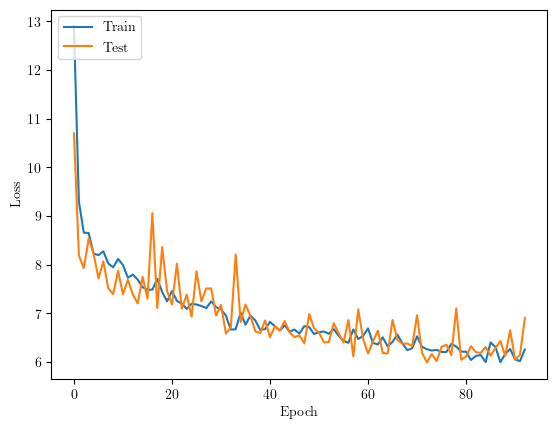

In [17]:
# Make the font the same as latex 
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.plot(history_tuned.history['loss'])
plt.plot(history_tuned.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
best_model.evaluate(X_test_scaled, y_test, verbose=0)

[7.238716125488281, 7.238716125488281]

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

model = RandomForestRegressor(max_depth=85, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, random_state=random_state) # Initialize model
scaler = StandardScaler() # Initialize scaler
pipeline = Pipeline(steps=[('normalize', scaler), ('model', model)]) # Create pipeline with scaler and model


In [20]:
%%time
pipeline_fit = pipeline.fit(X_train, y_train)

CPU times: user 7.09 s, sys: 107 ms, total: 7.19 s
Wall time: 7.19 s


In [21]:
%%time
sklearn_predictions = pipeline_fit.predict(X_test)

CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 315 ms


In [22]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test.values.ravel(), sklearn_predictions, squared=False)

1.6308346302435275

In [23]:
print(f"tensorflow score: {get_score(y_test.values.ravel(), test_predictions)}")
print(f"sklearn score: {get_score(y_test.values.ravel(), sklearn_predictions)}")

tensorflow score: 0.4207920792079208
sklearn score: 0.7293729372937293


In [24]:
scatter_plot_df = pd.DataFrame({
    's11_true': y_test.values.tolist() * 2,
    's11_prediction': np.concatenate((sklearn_predictions,test_predictions.reshape(-1))),
    's11_source': (['Sklearn'] * len(y_test.values.tolist())) + (['TensorFlow'] * len(y_test.values.tolist())),
    's11_color': (['red'] * len(y_test.values.tolist())) + (['blue'] * len(y_test.values.tolist()))
})

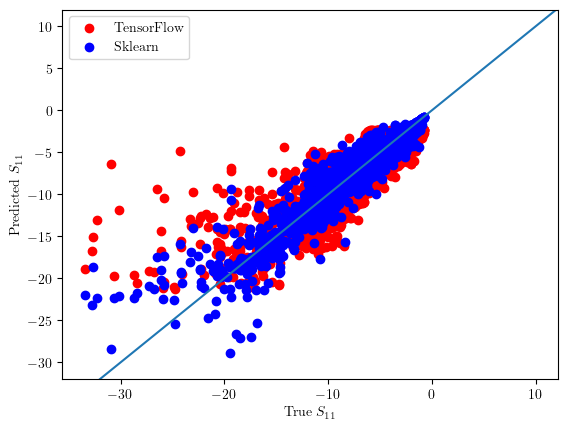

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, test_predictions, label="TensorFlow", c='r')
ax1.scatter(y_test, sklearn_predictions, label="Sklearn", c='b')
plt.xlabel('True $S_{11}$')
plt.ylabel('Predicted $S_{11}$')
plt.axline((-30,-30), (10,10))
plt.legend(loc='upper left')
plt.show()

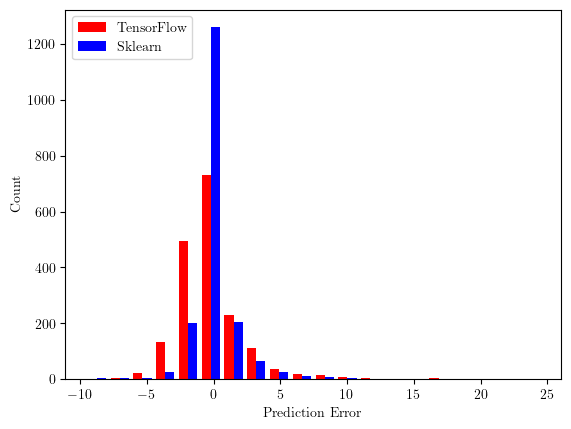

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
error_tensorflow = test_predictions.reshape(-1) - y_test
error_sklearn = sklearn_predictions - y_test
ax1.hist([error_tensorflow, error_sklearn], bins=20, color=['red', 'blue'], label=['TensorFlow', 'Sklearn'])
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.legend(loc='upper left')

In [27]:
analysis_df = X_test.copy()
analysis_df['dB(S(1,1)) []'] = y_test
analysis_df['tensorflow predicted s11'] = test_predictions.reshape(-1)
analysis_df['sklearn predicted s11'] = sklearn_predictions

In [28]:
analysis_df

,cpw_in [mm],feed_l [mm],ground_w [mm],patch_ground_w [mm],patch_l [mm],Freq [GHz],"dB(S(1,1)) []",tensorflow predicted s11,sklearn predicted s11
0,1.5,3.0,0.75,0.8,3.0,11.00,-1.054485,-2.322962,-1.108046
19,1.5,3.0,0.75,0.8,3.0,12.71,-5.117220,-5.259717,-5.351372
21,1.5,3.0,0.75,0.8,3.0,12.89,-5.847691,-6.153818,-7.314291
24,1.5,3.0,0.75,0.8,3.0,13.16,-9.464389,-6.427981,-7.235370
25,1.5,3.0,0.75,0.8,3.0,13.25,-7.263716,-6.486532,-6.260708
...,...,...,...,...,...,...,...,...,...
9063,2.5,3.0,1.25,1.2,4.0,17.66,-1.572713,-4.061556,-2.665163
9065,2.5,3.0,1.25,1.2,4.0,17.84,-1.314267,-3.763882,-1.902400
9075,2.5,3.0,1.25,1.2,4.0,18.74,-1.205531,-2.322962,-2.126182
9086,2.5,3.0,1.25,1.2,4.0,19.73,-1.885453,-2.322962,-1.787369
